# Putting the R(etrieval) in RAG

In [5]:
from openai import OpenAI
from pinecone import Pinecone, ServerlessSpec
import hashlib
import os
import re
from datetime import datetime, timezone
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import os
from dotenv import load_dotenv

# override so it overwrite the default keys with ones from .env
load_dotenv(override=True)

True

In [6]:
# Retrieve the API keys from user data
pinecone_key = os.environ.get('PINECONE_API_KEY')
openai_key = os.environ.get('OPENAI_API_KEY')

# Proxy is required for Pinecone client to work
proxy_url = None
if "https_proxy" in os.environ:
    proxy_url = os.environ['https_proxy']

# Initialize the OpenAI client with the API key from user data
client = OpenAI(
    api_key=openai_key
)

# Define constants for the Pinecone index, namespace, and engine
ENGINE = 'text-embedding-3-small'  # The embedding model to use (vector size 1,536)

# Initialize the Pinecone client with the retrieved API key
pc = Pinecone(
    api_key=pinecone_key,
    proxy_url=proxy_url,
)

In [12]:
INDEX_NAME = 'rag-basics'  # The name of the Pinecone index
NAMESPACE = 'default'  # The namespace to use within the index

# Function to get embeddings for a list of texts using the OpenAI API
def get_embeddings(texts, engine=ENGINE):
    # Create embeddings for the input texts using the specified engine
    response = client.embeddings.create(
        input=texts,
        model=engine
    )

    # Extract and return the list of embeddings from the response
    return [d.embedding for d in list(response.data)]

# Function to get embedding for a single text using the OpenAI API
def get_embedding(text, engine=ENGINE):
    # Use the get_embeddings function to get the embedding for a single text
    return get_embeddings([text], engine)[0]

# Test the functions by getting the length of a single embedding and a list of embeddings
len(get_embedding('hi')), len(get_embeddings(['hi', 'hello']))

(1536, 2)

In [11]:
if INDEX_NAME not in pc.list_indexes().names():  # need to create the index
    print(f'Creating index {INDEX_NAME}')
    pc.create_index(
        name=INDEX_NAME,  # The name of the index
        dimension=1536,  # The dimensionality of the vectors for our OpenAI embedder
        metric='cosine',  # The similarity metric to use when searching the index
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )

# Store the index as a variable
# NOTE: if it hangs here, it is a HTTP proxy issue
index = pc.Index(name=INDEX_NAME)

Creating index rag-basics


In [11]:
# index.delete(delete_all=True, namespace=NAMESPACE) # TO delete all vectors, be careful!

In [13]:
index.describe_index_stats()

{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '151',
                                    'content-type': 'application/json',
                                    'date': 'Thu, 05 Feb 2026 15:07:26 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '59',
                                    'x-pinecone-request-latency-ms': '58',
                                    'x-pinecone-response-duration-ms': '61'}},
 'dimension': 1536,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'storageFullness': 0.0,
 'total_vector_count': 0,
 'vector_type': 'dense'}

In [14]:
def my_hash(s):
    # Return the MD5 hash of the input string as a hexadecimal string
    return hashlib.md5(s.encode()).hexdigest()

my_hash('I love to hash it')

'ae76cc4dfd345ecaeea9b8ba0d5c3437'

In [15]:
def prepare_for_pinecone(texts, engine=ENGINE, urls=None):
    # Get the current UTC date and time
    now = datetime.now(timezone.utc).isoformat()

    # Generate vector embeddings for each string in the input list, using the specified engine
    embeddings = get_embeddings(texts, engine=engine)

    # Create tuples of (hash, embedding, metadata) for each input string and its corresponding vector embedding
    # The my_hash() function is used to generate a unique hash for each string, and the datetime.utcnow() function is used to generate the current UTC date and time
    responses = [
        (
            my_hash(text),  # A unique ID for each string, generated using the my_hash() function
            embedding,  # The vector embedding of the string
            dict(text=text, date_uploaded=now)  # A dictionary of metadata, including the original text and the current UTC date and time
        )
        for text, embedding in zip(texts, embeddings)  # Iterate over each input string and its corresponding vector embedding
    ]
    if urls and len(urls) == len(texts):
        for response, url in zip(responses, urls):
            response[-1]['url'] = url

    return responses


In [16]:
texts = ['hi']

In [17]:
_id, embedding, metadata = prepare_for_pinecone(texts)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  1536 
META: {'text': 'hi', 'date_uploaded': '2026-02-05T15:08:01.896998+00:00'}


In [18]:
urls = ['fake.url']
_id, embedding, metadata = prepare_for_pinecone(texts, urls=urls)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  1536 
META: {'text': 'hi', 'date_uploaded': '2026-02-05T15:08:05.777803+00:00', 'url': 'fake.url'}


In [19]:
def upload_texts_to_pinecone(texts, namespace=NAMESPACE, batch_size=None, show_progress_bar=False, urls=None):
    # Call the prepare_for_pinecone function to prepare the input texts for indexing
    total_upserted = 0
    if not batch_size:
        batch_size = len(texts)

    _range = range(0, len(texts), batch_size)
    for i in tqdm(_range) if show_progress_bar else _range:
        text_batch = texts[i: i + batch_size]
        if urls:
            url_batch = urls[i: i + batch_size]
            prepared_texts = prepare_for_pinecone(text_batch, urls=url_batch)
        else:
            prepared_texts = prepare_for_pinecone(text_batch)


        # Use the upsert() method of the index object to upload the prepared texts to Pinecone
        total_upserted += index.upsert(
            vectors=prepared_texts,
            namespace=namespace
        )['upserted_count']


    return total_upserted

In [20]:
# Call the upload_texts_to_pinecone() function with the input texts
print(upload_texts_to_pinecone(texts))

index.describe_index_stats()

1


{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '178',
                                    'content-type': 'application/json',
                                    'date': 'Thu, 05 Feb 2026 15:08:14 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '44',
                                    'x-pinecone-request-latency-ms': '43',
                                    'x-pinecone-response-duration-ms': '45'}},
 'dimension': 1536,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 1}},
 'storageFullness': 0.0,
 'total_vector_count': 1,
 'vector_type': 'dense'}

In [21]:
def query_from_pinecone(query, top_k=3, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

In [22]:
# test that the index has a vector
query_from_pinecone('hello')

[{'id': '49f68a5c8493ec2c0bf489821c21fc3b',
  'metadata': {'date_uploaded': '2026-02-05T15:08:13.821403+00:00',
               'text': 'hi'},
  'score': 0.808795929,
  'values': []}]

In [23]:
import hashlib

def delete_texts_from_pinecone(texts, namespace=NAMESPACE):
    # Compute the hash (id) for each text
    hashes = [hashlib.md5(text.encode()).hexdigest() for text in texts]

    # The ids parameter is used to specify the list of IDs (hashes) to delete
    return index.delete(ids=hashes, namespace=namespace)

# delete our text
delete_texts_from_pinecone(texts)


{'_response_info': {'raw_headers': {'date': 'Thu, 05 Feb 2026 15:08:31 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-pinecone-request-lsn': '2',
   'x-pinecone-request-logical-size': '0',
   'x-pinecone-request-latency-ms': '127',
   'x-envoy-upstream-service-time': '128',
   'x-pinecone-response-duration-ms': '130',
   'grpc-status': '0',
   'server': 'envoy'}}}

In [24]:
index.describe_index_stats()

{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '151',
                                    'content-type': 'application/json',
                                    'date': 'Thu, 05 Feb 2026 15:08:34 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '5',
                                    'x-pinecone-request-latency-ms': '4',
                                    'x-pinecone-response-duration-ms': '6'}},
 'dimension': 1536,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'storageFullness': 0.0,
 'total_vector_count': 0,
 'vector_type': 'dense'}

# "Borrowing" Government Data

In [38]:
base_url = 'https://www.ssa.gov'
questions_url = base_url + '/faqs/en/questions/'
print(questions_url)

https://www.ssa.gov/faqs/en/questions/


In [45]:
import urllib3, os
from playwright.async_api import async_playwright
urllib3.disable_warnings()

async def download_page(url):
    async with async_playwright() as p:
        browser = await p.chromium.launch()
        page = await browser.new_page()
        await page.goto(url, wait_until="networkidle")
        html = await page.content()
        await browser.close()
    return html
        
# running Playwright’s sync API inside Jupyter/IPython, which already has an asyncio loop. Use the async API in notebooks.
async def find_links_with_pattern(url, pattern):
    html = await download_page(url)
    
    # Create a BeautifulSoup object
    soup = BeautifulSoup(html, 'html.parser')
    
    # Compile the regex pattern
    regex = re.compile(pattern)
    
    # Find all 'a' tags with href attribute matching the pattern
    links = soup.find_all('a', href=regex)
    
    # Extract and return the href values
    return [base_url + link.get('href') for link in links]

# Example usage
pattern = r'^/faqs/en/questions'

urls = await find_links_with_pattern(questions_url, pattern)
print(len(urls))
urls[0]

168


'https://www.ssa.gov/faqs/en/questions/KA-01759.html'

In [83]:
dirty_government_docs = []
for url in tqdm(urls):
    html = await download_page(url)
    soup = BeautifulSoup(html, 'html.parser')
    dirty_government_docs.append((soup.find('article').get_text(), url))

 18%|████████████▎                                                        | 30/168 [00:51<04:16,  1.86s/it]Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
playwright._impl._errors.TargetClosedError: Target page, context or browser has been closed
100%|████████████████████████████████████████████████████████████████████| 168/168 [04:51<00:00,  1.73s/it]


In [84]:
dirty_government_docs[0]

("How do I file W-2s, W-2Cs, and W-3s for my employees?January 29, 2026\xa0·\xa0En español\xa0·\xa0ShareEmployers and third parties can easily file wage reports with us electronically or by paper (limitations apply). The Internal Revenue Service (IRS) has issued final regulations that reduce the electronic filing threshold from 250 W-2s to 10 information returns, effective January 2024. If you file 10 or more information returns (such as Forms W-2 or 1099), you must file electronically unless the IRS grants a waiver or exemption.There are three ways to file electronically:Use our free product, W-2 Online, which allows you to file W-2s and W-2Cs right from our Business Services Online (BSO) webpage.Use software that produces W-2 forms in the Electronic Filing W-2 (EFW2) format and upload your file on our BSO webpage.Use a commercial software product that allows you to file W-2s electronically with us using the software.Note: You also have the option for a third party to prepare the W-2s

In [85]:
def clean_string(text):  # courtesy of Claude 3.5 Sonnet
    # Remove extra whitespace, including newlines
    text = re.sub(r'\s+', ' ', text)
    # Remove any leading/trailing whitespace
    text = text.strip()
    # Remove common filler phrases
    filler_phrases = [
        r"Skip to content", r"Skip to main content", r"Menu", r"Sign in", r"Print", r"Views:", r"Comments \(0\)",
        r"Footer menu", r"Give us Feedback.", r"Did this answer your question?", r"No Yes No", r"Thanks for your feedback."
    ]
    for phrase in filler_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)
    # Remove any remaining brackets and their contents
    text = re.sub(r'\[.*?\]', '', text)
    # Remove any remaining parentheses and their contents
    text = re.sub(r'\(.*?\)', '', text)
    # Remove any URLs
    text = re.sub(r'http\S+', '', text)
    # Remove any remaining special characters
    text = re.sub(r'[^\w\s\.\,\?\!]', '', text)
    # Remove extra spaces that may have been created
    text = re.sub(r'\s+', ' ', text).strip()

    text = text.split('FAQ Home Topics')[-1]
    text = text.split('More Information')[0]
    text = text.split('Footer ?')[0]

    text = text.strip()
    return text

In [86]:
government_docs = []
for body, url in dirty_government_docs:
    government_docs.append(dict(text=clean_string(body), url=url))

In [87]:
government_docs[0]

{'text': 'How do I file W2s, W2Cs, and W3s for my employees?January 29, 2026 En español ShareEmployers and third parties can easily file wage reports with us electronically or by paper . The Internal Revenue Service has issued final regulations that reduce the electronic filing threshold from 250 W2s to 10 information returns, effective January 2024. If you file 10 or more information returns , you must file electronically unless the IRS grants a waiver or exemption.There are three ways to file electronicallyUse our free product, W2 Online, which allows you to file W2s and W2Cs right from our Business Services Online webpage.Use software that produces W2 forms in the Electronic Filing W2 format and upload your file on our BSO webpage.Use a commercial software product that allows you to file W2s electronically with us using the software.Note You also have the option for a third party to prepare the W2s and file them electronically with us. The third party normally charges a fee.',
 'url

In [88]:
government_docs[-1]

{'text': 'I received a letter claiming to be from the Social Security Administration with an 800 I do not recognize. Is it really from SSA?April 7, 2022 ShareWe routinely release outreach notices in an effort to identify people eligible for Social Security benefits. From December 2020 through June 2022, we are mailing outreach notices to people who may be eligible for Supplemental Security Income payments. SSI makes payments to disabled adults and children who have limited income and resources.We established a dedicated phone line with a team of specialized employees to help people who receive this notice. These employees are SSI experts who will help callers explore eligibility and assist with SSI applications, if appropriate at the time of the call. We also established a separate phone number for people to call who need help in Spanish.',
 'url': 'https://www.ssa.gov/faqs/en/questions/KA-10050.html'}

In [89]:
# index.delete(delete_all=True, namespace=NAMESPACE) # TO delete all vectors, be careful!

In [90]:
BATCH_SIZE = 32
upload_texts_to_pinecone(
    texts=[g['text'] for g in government_docs],
    batch_size=BATCH_SIZE, show_progress_bar=True, 
    urls=[g['url'] for g in government_docs]
)

100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.51s/it]


168

In [91]:
index.describe_index_stats()

{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '182',
                                    'content-type': 'application/json',
                                    'date': 'Thu, 05 Feb 2026 15:56:07 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '39',
                                    'x-pinecone-request-latency-ms': '39',
                                    'x-pinecone-response-duration-ms': '40'}},
 'dimension': 1536,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 168}},
 'storageFullness': 0.0,
 'total_vector_count': 168,
 'vector_type': 'dense'}

In [100]:
query = 'I lost my medicare card'

results = query_from_pinecone(query, top_k=10)
for result in results:
    print(result['metadata']['url'], result['score'], result['metadata']['text'][-50:])

https://www.ssa.gov/faqs/en/questions/KA-01735.html 0.670524597 o order a replacement card to be sent in the mail.
https://www.ssa.gov/faqs/en/questions/KA-10076.html 0.628311217 ces.You can also call 1800MEDICARE for assistance.
https://www.ssa.gov/faqs/en/questions/KA-02017.html 0.489760399 ber card?How do I get a replacement Medicare card?
https://www.ssa.gov/faqs/en/questions/KA-10115.html 0.463540077 ww.medicare.govbasics or call them at 18006334227.
https://www.ssa.gov/faqs/en/questions/KA-02131.html 0.456921577 more information go to our Medicare Benefits page.
https://www.ssa.gov/faqs/en/questions/KA-02639.html 0.453510284 and Human Services OIG or by phone at 18004478744.
https://www.ssa.gov/faqs/en/questions/KA-02125.html 0.444903374 or more information read our Medicare publication.
https://www.ssa.gov/faqs/en/questions/KA-02713.html 0.441551208 rmation, go to the How to drop Part A Part B page.
https://www.ssa.gov/faqs/en/questions/KA-02244.html 0.440689087 Income, contact 

In [101]:
results

[{'id': '421147ae7ad3d506f3543f96e9a90ca4',
  'metadata': {'date_uploaded': '2026-02-05T15:55:51.655833+00:00',
               'text': 'How do I get a replacement Medicare card?February 28, '
                       '2023 En español ShareIf your Medicare card was lost, '
                       'stolen, or destroyed, you can request a replacement '
                       'online at Medicare.gov.You can an official copy of your '
                       'card from your online Medicare account or call '
                       '1800MEDICARE to order a replacement card to be sent in '
                       'the mail.',
               'url': 'https://www.ssa.gov/faqs/en/questions/KA-01735.html'},
  'score': 0.670524597,
  'values': []},
 {'id': 'ea916ae1774d4a9e5cbe77714f83c0a2',
  'metadata': {'date_uploaded': '2026-02-05T15:55:50.411313+00:00',
               'text': 'Can I get a new Medicare card for a beneficiary?March '
                       '13, 2024 ShareIf your beneficiarys Medicare 

# Using Open Source Embedders

In [103]:
from sentence_transformers import SentenceTransformer, util

open_source_embedder = SentenceTransformer('all-MiniLM-L6-v2')

open_source_embedder.encode(['hi', 'hello', 'sup']).shape

# It's that easy! The hard part is evaluating them :)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


(3, 384)

In [86]:
open_source_embedder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# Synthetic Test Data Generation

In [104]:
# pip install langchain langchain-openai pydantic
import os
from typing import List, Literal
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# ---- Structured schema ----
class SyntheticQuestions(BaseModel):
    """Ten user questions derived strictly from the provided document text."""
    english_questions: List[str] = Field(
        ...,
        description=(
            "Exactly 5 English questions"
        ),
    )
    spanish_questions: List[str] = Field(
        ...,
        description=(
            "Exactly 2 Spanish questions"
        ),
    )
    chinese_questions: List[str] = Field(
        ...,
        description=(
            "Exactly 2 Chinese questions"
        ),
    )
    french_questions: List[str] = Field(
        ...,
        description=(
            "Exactly 1 French question"
        ),
    )
# ---- LLM & prompt ----
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=1.0)

prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are generating fair user questions that can be "
     "answered strictly from the provided document. Do not add external facts."
     "Everything must be answerable using the document below"),
    ("human",
     "I am designing a chatbot that uses the document below.\n\n"
     "Please write 10 distinct questions an average (non-expert) user might ask that "
     "can DEFINITELY be answered using only this document. Make them a bit "
     "confusing (but fair) to stress-test retrieval.\n\n"
     "Document:\n{document}")
])

structured_llm = llm.with_structured_output(SyntheticQuestions)
chain = prompt | structured_llm


In [105]:
questions = chain.invoke({'document': government_docs[0]["text"]})

In [106]:
questions.english_questions

['What is the minimum number of W2s I must file electronically starting January 2024?',
 'Can a third party file W2s electronically on my behalf, and do they usually charge for this service?',
 'If I have fewer than 10 W2 forms, am I required to file electronically or can I still send paper forms?',
 'Is there a free option provided by the IRS to file W2 and W2C forms electronically?',
 'What are the three methods available to file W2s electronically according to the document?']

In [107]:
print(government_docs[0]["text"])

How do I file W2s, W2Cs, and W3s for my employees?January 29, 2026 En español ShareEmployers and third parties can easily file wage reports with us electronically or by paper . The Internal Revenue Service has issued final regulations that reduce the electronic filing threshold from 250 W2s to 10 information returns, effective January 2024. If you file 10 or more information returns , you must file electronically unless the IRS grants a waiver or exemption.There are three ways to file electronicallyUse our free product, W2 Online, which allows you to file W2s and W2Cs right from our Business Services Online webpage.Use software that produces W2 forms in the Electronic Filing W2 format and upload your file on our BSO webpage.Use a commercial software product that allows you to file W2s electronically with us using the software.Note You also have the option for a third party to prepare the W2s and file them electronically with us. The third party normally charges a fee.


In [108]:
synthetic_questions = []
from random import sample

# generate synthetic test data for a sample  of the urls found
SAMPLE = .2
for i, government_doc in enumerate(tqdm(sample(government_docs, int(len(government_docs) * SAMPLE)))):
        
    result = chain.invoke({"document": government_doc['text']})
    try:
        for language in ('english', 'spanish', 'french', 'chinese'):
            for question in getattr(result, f'{language}_questions'):
                synthetic_questions.append(
                dict(
                    language=language, 
                    query=question, 
                    expected_hash=my_hash(government_doc['text'])
                )
            )
    except Exception as e:
        print(f'Could not generate questions for index {i}: {e}')
    

100%|██████████████████████████████████████████████████████████████████████| 33/33 [02:05<00:00,  3.81s/it]


In [109]:
len(synthetic_questions)

340

In [110]:
synthetic_questions[0]

{'language': 'english',
 'query': 'How were Social Security numbers assigned before 2011?',
 'expected_hash': 'a1cb32de3b08a5a73da3deb2f162e365'}

In [111]:
def test_query(query, expected_hash, language, top_k=10):
    results = query_from_pinecone(query, top_k=top_k)
    top_result_correct = results[0]['id'] == expected_hash  # accuracy
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)  # Recall@top_k (10, etc)
    return dict(
        result_in_pinecone_list=result_in_pinecone_list, top_result_correct=top_result_correct,
        language=language, expected_hash=expected_hash, top_hash=results[0]['id']
    )

In [112]:
test_query(**synthetic_questions[0])

{'result_in_pinecone_list': True,
 'top_result_correct': True,
 'language': 'english',
 'expected_hash': 'a1cb32de3b08a5a73da3deb2f162e365',
 'top_hash': 'a1cb32de3b08a5a73da3deb2f162e365'}

In [113]:
synthetic_test_results = []
for synthetic_question in tqdm(synthetic_questions):
    synthetic_test_results.append(test_query(**synthetic_question))

100%|████████████████████████████████████████████████████████████████████| 340/340 [03:14<00:00,  1.75it/s]


result_in_pinecone_list    0.979412
top_result_correct         0.867647
dtype: float64


Matplotlib is building the font cache; this may take a moment.


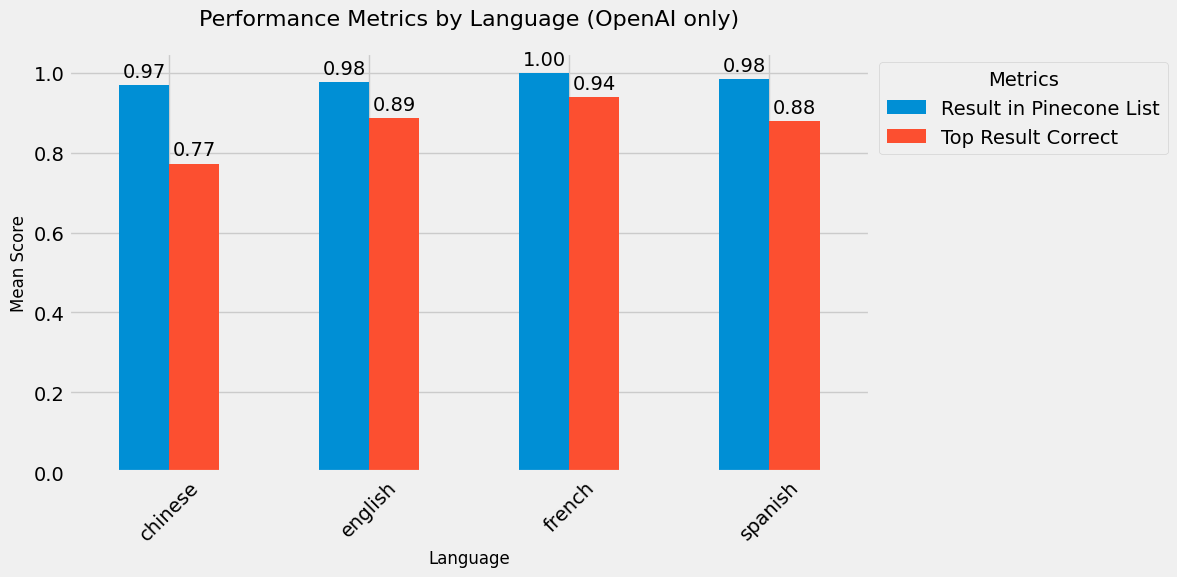

In [115]:
import pandas as pd
results_df = pd.DataFrame(synthetic_test_results)

print(results_df[['result_in_pinecone_list', 'top_result_correct']].mean())

import matplotlib.pyplot as plt

# Assuming you've already created results_df
grouped_data = results_df.groupby('language')[['result_in_pinecone_list', 'top_result_correct']].mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')
# sns.set_palette("deep")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language (OpenAI only)', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

# Add a legend
ax.legend(['Result in Pinecone List', 'Top Result Correct'], title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Making Retrieval Better with [Cohere](cohere.com/rerank)'s Re-Rank


"Rerank provides a powerful semantic boost to the search quality of any keyword or vector search system without requiring any overhaul or replacement."

In [116]:
import cohere

co = cohere.Client(os.environ.get('COHERE_API_KEY'))

In [117]:
docs = [
    "Carson City is the capital city of the American state of Nevada.",
    "The Commonwealth of the Northern Mariana Islands is a group of islands in the Pacific Ocean. Its capital is Saipan.",
    "Capitalization or capitalisation in English grammar is the use of a capital letter at the start of a word. English usage varies from capitalization in other languages.",
    "Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district.",
    "Capital punishment (the death penalty) has existed in the United States since beforethe United States was a country. As of 2017, capital punishment is legal in 30 of the 50 states.",
]

response = co.rerank(
    model="rerank-english-v3.0",
    query="What is the capital of the United States?",
    documents=docs,
    top_n=1,
)

docs[response.results[0].index] # re-ranks the docs so that the first one is the most semantically similar

'Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district.'

In [118]:
def test_query_with_cohere(query, expected_hash, language, top_k=10):
        
    results = query_from_pinecone(query, top_k=top_k)
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)    
    docs = [result['metadata']['text'] for result in results]   
        
    response = co.rerank(
        model="rerank-multilingual-v3.0",
        query=query,
        documents=docs,
        top_n=1,
    )

    top_doc = docs[response.results[0].index]
    top_result_correct = my_hash(top_doc) == expected_hash
    
    return dict(
        result_in_pinecone_list=result_in_pinecone_list, top_result_correct=top_result_correct,
        language=language, expected_hash=expected_hash, top_hash=results[0]['id']
    )

In [119]:
test_query_with_cohere(**synthetic_questions[0])

{'result_in_pinecone_list': True,
 'top_result_correct': True,
 'language': 'english',
 'expected_hash': 'a1cb32de3b08a5a73da3deb2f162e365',
 'top_hash': 'a1cb32de3b08a5a73da3deb2f162e365'}

In [121]:
len(synthetic_questions)

340

In [125]:
# Trial key is limited to 10 API calls / minute
import time
from cohere.errors import TooManyRequestsError
synthetic_test_results_cohere = []
for synthetic_question in tqdm(synthetic_questions):
    try:
        synthetic_test_results_cohere.append(test_query_with_cohere(**synthetic_question))
    except TooManyRequestsError as e:
        if e.status_code == 429: # TooManyRequestError
            time.sleep(60) # 1 minute
            synthetic_test_results_cohere.append(test_query_with_cohere(**synthetic_question))
        else:
            raise e

100%|████████████████████████████████████████████████████████████████████| 340/340 [38:16<00:00,  6.76s/it]


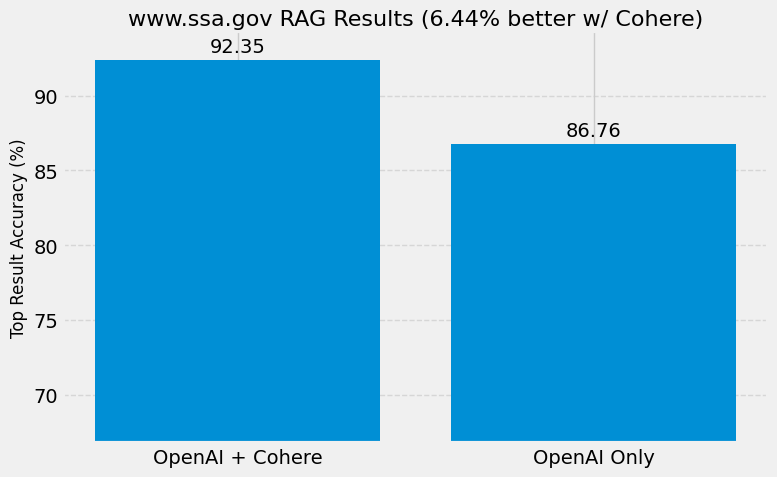

In [126]:
import matplotlib.pyplot as plt

# Data
data = {
    'OpenAI + Cohere': pd.Series([s['top_result_correct'] for s in synthetic_test_results_cohere]).mean() * 100,
    'OpenAI Only': pd.Series([s['top_result_correct'] for s in synthetic_test_results]).mean() * 100
}

percent_change = round((data['OpenAI + Cohere'] - data['OpenAI Only']) / data['OpenAI Only'] * 100, 2)

# Set the style and color palette
plt.style.use('fivethirtyeight')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))  # Reduced from (10, 6)

# Plot the data
bars = ax.bar(data.keys(), data.values())

# Customize the plot
ax.set_title(
    f'{base_url.split("//")[-1]} RAG Results ({percent_change}% {"better" if percent_change > 0 else "worse"} w/ Cohere)', 
    fontsize=16, pad=4)
ax.set_ylabel('Top Result Accuracy (%)', fontsize=12)
ax.tick_params(axis='x')

# Add value labels on top of each bar
ax.bar_label(bars, fmt='%.2f', padding=3)

# Adjust y-axis to start from 0.7 for better visualization of differences
ax.set_ylim(min(data.values()) - 20, max(data.values()) + 2)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [127]:
synthetic_test_results[0]

{'result_in_pinecone_list': True,
 'top_result_correct': True,
 'language': 'english',
 'expected_hash': 'a1cb32de3b08a5a73da3deb2f162e365',
 'top_hash': 'a1cb32de3b08a5a73da3deb2f162e365'}

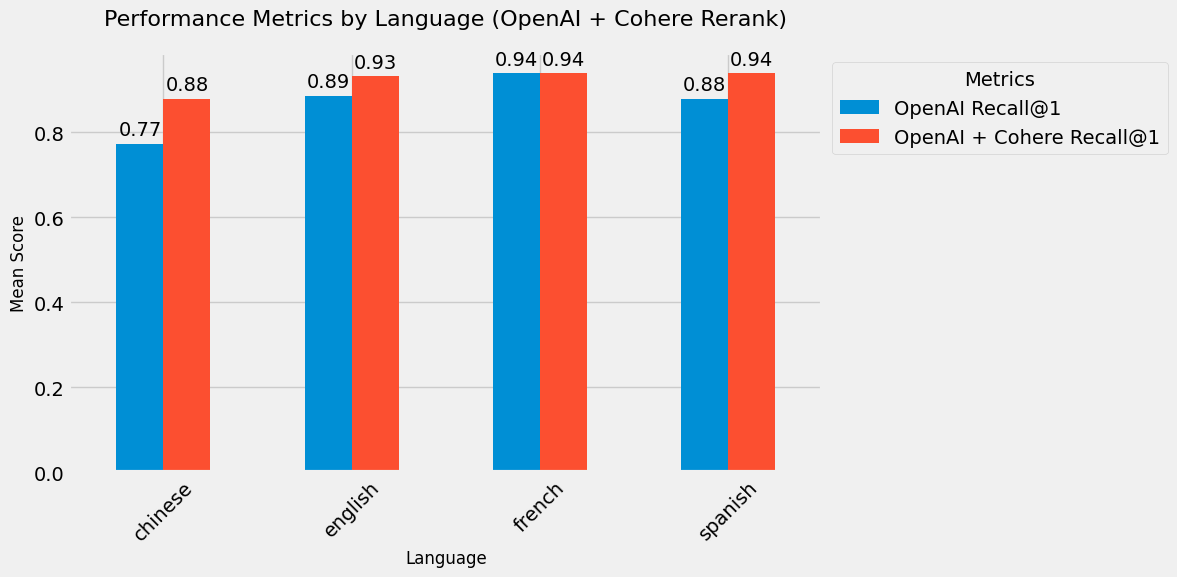

In [129]:
import pandas as pd
results_df = pd.DataFrame({
    'language': [_['language'] for _ in synthetic_test_results],
    'OpenAI Recall@1': [_['top_result_correct'] for _ in synthetic_test_results],
    'OpenAI + Cohere Recall@1': [_['top_result_correct'] for _ in synthetic_test_results_cohere]
})
# print(results_df[['result_in_pinecone_list', 'top_result_correct']].mean())

grouped_data = results_df.groupby('language').mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language (OpenAI + Cohere Rerank)', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

# Add a legend
ax.legend(title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()